In [79]:
import ase
from ase.io import read, write
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import os
import subprocess

In [80]:
# In this first section we  will define all the output files
out_supercell = "SuperCells/SiO2_Supercell.xyz" 
out_pre_solvated_gro = "PreSolvated/SiO2_Supercell_vacuum.gro"
out_postsolvated_gro = "Solvated/SiO2_Supercell_solvated.gro"

In [81]:
# Read the CIF file for the primitive cell of SiO2
primitive = read("PrimitiveCells/SiO2_Primitive.cif")

In [82]:
# Repeat the primitive cell in order to create the desired supercell and visualize the result
supercell = primitive.repeat((3, 3, 2))
supercell.write(out_supercell, format="extxyz")




# view(supercell)

In [83]:
# Modify the box dimensions in order to create the vacuum for water
old_volume = supercell.get_volume()
old_supercell = supercell.get_cell()
supercell.cell[2, 2] += 25.0
new_volume = supercell.get_volume()
print("Old volume: ", old_volume)
print("New volume: ", new_volume)
print(f"The old supercell is equal to: {old_supercell}")
print(f"The new supercell is equal to: {supercell.get_cell()}")
#view(supercell)

Old volume:  2036.360773108868
New volume:  6745.449770012124
The old supercell is equal to: Cell([[14.748000000000001, 0.0, 0.0], [-7.373999999999998, 12.772142655012903, 0.0], [0.0, 0.0, 10.8108]])
The new supercell is equal to: Cell([[14.748000000000001, 0.0, 0.0], [-7.373999999999998, 12.772142655012903, 0.0], [0.0, 0.0, 35.8108]])


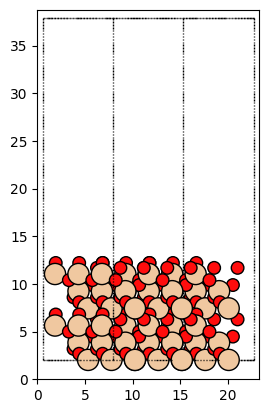

In [84]:
# Visulize the supercell with the vacuum

plot_atoms(supercell, rotation='270x', show_unit_cell=2)
plt.show()

In [85]:
# As a preliminary check we have to: check and remove each file if it exists
for file_path in [out_pre_solvated_gro, out_postsolvated_gro]:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    else:
        print(f"File not found: {file_path}")


        # We do that since gromacs will not overwrite the foiles and it will create a mess in the folder

Deleted: PreSolvated/SiO2_Supercell_vacuum.gro
Deleted: Solvated/SiO2_Supercell_solvated.gro


In [ ]:
# Save the modified supercell with vacuum in a GROMACS format
supercell.write(out_pre_solvated_gro, format="gromacs")
subprocess.run(["gmx", "solvate", "-cp", out_pre_solvated_gro, "-o", out_postsolvated_gro])
solvated = read(out_postsolvated_gro)
print(solvated.get_cell())


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------

          :-) GROMACS - gmx solvate, 2023.3-Ubuntu_2023.3_1ubuntu3 (-:

Executable:   /usr/bin/gmx
Data prefix:  /usr
Working dir:  /home/forina/Documents/Simulations/SamplePreparation
Command line:
  gm

          :-) GROMACS - gmx solvate, 2023.3-Ubuntu_2023.3_1ubuntu3 (-:

Executable:   /usr/bin/gmx
Data prefix:  /usr
Working dir:  /home/forina/Documents/Simulations/SamplePreparation
Command line:
  gmx solvate -cp PreSolvated/SiO2_Supercell_vacuum.gro -o Solvated/SiO2_Supercell_solvated.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...
Generating solvent configuration
Will generate new solvent configuration of 1x1x2 boxes
Solvent box contains 1068 atoms in 356 residues
Removed 432 solvent atoms due to solvent-solvent overlap
Removed 216 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms):   140 residues
Generated solvent containing 420 atoms in 140 residues
Writing generated configuration to Solvated/SiO2_Supercell_solvated.gro

Output configuration contains 582 atoms in 141 residues
Volume                 :     6.74543 (nm^3)
Density                :     1419.61 (g/l)
Num

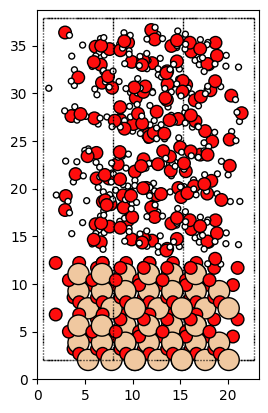

In [ ]:

plot_atoms(solvated, rotation='270x', show_unit_cell=2)
plt.show()


In [38]:
print(new_volume - old_volume)

4709.088996903256
